In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
import missingno as msno
import pdb
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/jbenjamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/jbenjamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/jbenjamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/jbenjamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/jbenjamin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate bin

## Read in Pickle

In [2]:
cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')

## Convert Features to Categorical

In [3]:
categorical_features = ['bathrooms','bedrooms','zipcode','yr_built','grade','condition','view','floors']

In [4]:
# converts all categorical features to a categorical type
for feature in categorical_features:
    cleaned_KC[feature] = cleaned_KC[feature].astype('category')
cleaned_KC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21301 entries, 0 to 21347
Data columns (total 15 columns):
id               21301 non-null int64
date             21301 non-null object
price            21301 non-null float64
bedrooms         21301 non-null category
bathrooms        21301 non-null category
sqft_living      21301 non-null int64
sqft_lot         21301 non-null int64
floors           21301 non-null category
view             21301 non-null category
condition        21301 non-null category
grade            21301 non-null category
yr_built         21301 non-null category
zipcode          21301 non-null category
sqft_living15    21301 non-null int64
sqft_lot15       21301 non-null int64
dtypes: category(8), float64(1), int64(5), object(1)
memory usage: 1.5+ MB


## Review Correlation and VIF 

#### Calculate Pearson's R Value

In [5]:
cleaned_KC.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.677350
sqft_living15    0.593302
sqft_lot         0.083969
sqft_lot15       0.077855
id              -0.015326
Name: price, dtype: float64

#### Calculate VIF

Based on the first run of the VIF, Sqft_living and sqft_living15 are thought to have multi-collinearity, thus we will drop sqft_living15

In [6]:
# select only columns with datatype int64 or float 64
numeric_cleaned_KC = cleaned_KC.select_dtypes(include=['int64','float64'])

# then drop the sqft_living15 and id column to reduce noise.
numeric_cleaned_KC = numeric_cleaned_KC.drop(axis=1, columns=['sqft_living15', 'id'])

vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF Factor"] = [variance_inflation_factor(numeric_cleaned_KC.values, i) for i in range(numeric_cleaned_KC.shape[1])]

# simply label the scores with their related columns
vif["features"] = numeric_cleaned_KC.columns

vif.round(1)

,VIF Factor,features
0,6.6,price
1,7.0,sqft_living
2,2.3,sqft_lot
3,2.5,sqft_lot15


## Linear Regression
##### Price vs Sqft_living

#### Calculate Regression Line

In [7]:
# Transforms a dataframe into a np.array
X = cleaned_KC['sqft_living'].values.reshape(-1,1)
y = cleaned_KC['price'].values.reshape(-1,1)

# Create a Linear Regression object and fit a line using X and y
reg = LinearRegression()
reg.fit(X, y)

# using that line, make predictions for y using X
predictions = reg.predict(X)

#### Plot Regression against Scatterplot

In [8]:
# Look into Seaborns scatterplot for a new look

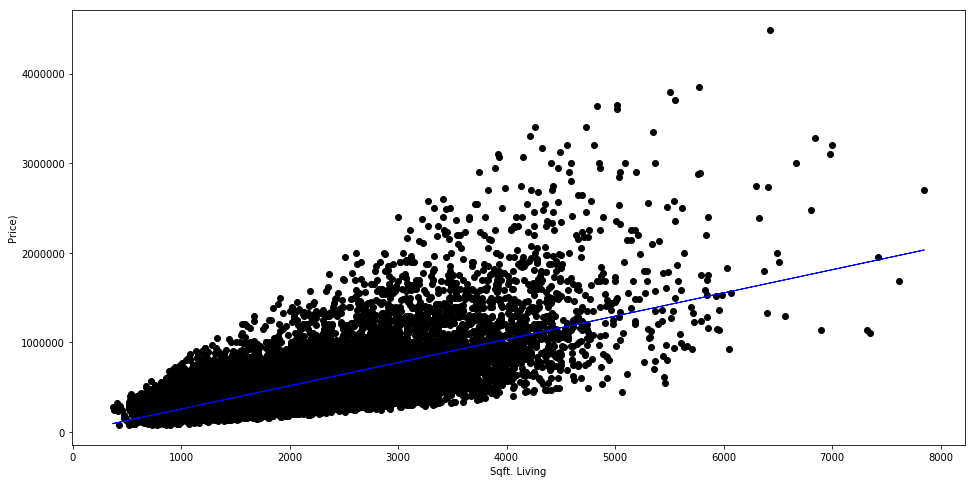

In [9]:
# Make a 16x8 figure that has...
plt.figure(figsize=(16, 8))

# ...a scatter plot of sqft_living vs price...
plt.scatter(
    cleaned_KC['sqft_living'],
    cleaned_KC['price'],
    c='black'
)

# ...plot the regression line...
plt.plot(
    cleaned_KC['sqft_living'],
    predictions,
    c='blue',
    linewidth=1
)

# ...set the labels and show
plt.xlabel("Sqft. Living")
plt.ylabel("Price)")
plt.show()

#### Calculate OLS Regression Results

In [10]:
X = cleaned_KC['sqft_living']
y = cleaned_KC['price']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:12:16   Log-Likelihood:            -2.9433e+05
No. Observations:               21301   AIC:                         5.887e+05
Df Residuals:                   21299   BIC:                         5.887e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2283.2967   4289.244     -0.532      

/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### <span style="color:blue">Our Linear Regression R-Squared result:</span><span style="color:red"> .52</span>

## Multiple Linear Regression including Categorical Variables
### Run Train/Test split

#### convert to dummy variables dataframe

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer

# target = titanic2.survived.values
# features = titanic2[['pclass', 'sex', 'age', 'fare', 'embarked']]

# This dataset contains some categorical variables ("pclass", "sex" and "embarked")
categorial_columns = ['bathrooms','bedrooms','grade','view','floors']

# numerical variables ("age" and "fare").
numerical_columns = ['price','sqft_lot','sqft_living15', 'sqft_lot15']

preprocess = make_column_transformer(
    (numerical_columns, StandardScaler()),
    (categorial_columns, OneHotEncoder())
)

test_array = preprocess.fit_transform(cleaned_KC).toarray()

test_df = pd.DataFrame(test_array)
test_df.head()

/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,-0.932072,-0.226712,-0.945868,-0.263050,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.027033,-0.187680,-0.425240,-0.188067,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.059204,-0.120060,1.106895,-0.172120,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.227289,-0.242648,-0.916118,-0.287555,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.057924,-0.167134,-0.261614,-0.193194,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
categorial_columns = ['bathrooms','bedrooms','grade','view','floors']
non_categorial_columns = ['id','date','price','sqft_lot','condition','yr_built','zipcode','sqft_living15', 'sqft_lot15']

# This replaces categorical columns with dummy variables, and drops non categorical columns
dummies_df = pd.get_dummies(cleaned_KC, columns=categorial_columns).drop(columns=non_categorial_columns)

#### Create X & Y Train/Test variables

In [13]:
# This sets X to a dataframe consisting of columns with dummy variables & without extra columns.
X = dummies_df

# this simply sets y to the price column of the dataframe
y = cleaned_KC['price']

# This runs a train/test split with .20 of the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### Calculate OLS

In [14]:
# Simply adding a y-intercept column.
X2 = sm.add_constant(X_train)

# Using statsmodels, run an Ordinary Least Squares test using the array of y values, and the dataframe of x_test values and fit a line to it. 
est = sm.OLS(y_train, X2).fit()
print(est.summary())

/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     680.1
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:15:05   Log-Likelihood:            -2.3259e+05
No. Observations:               17040   AIC:                         4.653e+05
Df Residuals:                   16999   BIC:                         4.656e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.258e+05   1.94e+04     21.

#### Calculate skLearn r2

In [15]:
# Creates a Linear Regression object
lin_reg = LinearRegression()

# Train the Regression object to fit a line with train data
lin_reg.fit(X_train, y_train)

# using that line, predict y values against x_test values.
y_pred = lin_reg.predict(X_test)

# Use sklearn.metrics.r2_score to determine r-squared based on y_test values and y_pred values.
r2_score(y_test, y_pred)

0.6262166583650244

### <span style="color:blue">Our Multiple Linear Regression R-Squared result:</span><span style="color:green"> .62</span>

#### Calculate skLearn MSE

In [16]:
mean_squared_error(y_test, y_pred)

39659678425.951904

# Lasso/Ridge

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [26]:
lasso = Lasso()
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,5,10,20]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv = 5)
ridge_regressor.fit(X_test,y_test)

/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.97077e-20): result may not be accurate.
  overwrite_a=True).T
/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.97583e-20): result may not be accurate.
  overwrite_a=True).T
/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.91362e-20): result may not be accurate.
  overwrite_a=True).T
/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.04474e-20): result may not be accurate.
  overwrite_a=True).T
/Users/jbenjamin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.87387e-20): result may not be accurate.
  overwrite_a=True).T
/User

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 1}
-40577836999.0048
